In [1]:
import pandas as pd
import numpy as np

# Energy Imports and Exports

In [3]:
# See available downloaded datasets
%ls data/

25100029-fra.zip  25100029-fra.zip.1  download_data.sh


In [4]:
df_impexp = pd.read_csv("../data/imports-exports-data-visualization.csv", encoding = "ISO-8859-1")

In [5]:
# Turn all confidentials to NaNs
df_impexp.replace("Confidential", np.nan, inplace=True)
df_impexp.replace("confidential", np.nan, inplace=True)


# Turn "object" types to numeric types where possible
# pd.to_numeric(df_impexp['Value']) # nfer_objects().dtypes
df_impexp['Value'] = pd.to_numeric(df_impexp['Value'])
df_impexp.dtypes

Period                                object
Product                               object
Product subtype/Category/Commodity    object
Mode of transportation                object
Origin                                object
Destination                           object
Port                                  object
Activity                              object
Units                                 object
Value                                 object
dtype: object

In [7]:
# Separate year and quarter
try:
    df_impexp['Year'] = df_impexp['Period'].apply(lambda s:s[:-2])
    df_impexp['Quarter'] = df_impexp['Period'].apply(lambda s:s[-1:])
    df_impexp['Quarter'] = pd.to_numeric(df_impexp['Quarter'])
    df_impexp['Year'] = pd.to_numeric(df_impexp['Year'])

    #     df_impexp.drop(['Period'], axis=1)
    del df_impexp['Period']
except Exception:
    print('already deleted')

In [8]:
# Careful not to run this twice
df_impexp = df_impexp[['Year', 'Quarter'] + list(df_impexp.columns[:-2])]

In [9]:
# df_impexp.set_index(['Year', 'Quarter'], inplace=True)
periods = pd.PeriodIndex(year=df_impexp['Year'], quarter=df_impexp['Quarter'])
df_impexp.index = periods.to_timestamp('D', 'end')

In [10]:
# df_impexp[df_impexp['Activity'] = "Export", 'Value'] = 
# - df_impexp[df_impexp['Activity'] == "Export",:, 'Value']
# df_impexp.loc[df_impexp['Activity'] == "Export"]
df_impexp['Activity'].unique()
df_impexp = (df_impexp[(df_impexp['Activity'] != 'Import / Re-exports') & (df_impexp['Activity'] != 'Re-export / Imports')])

# Just count re-imports as imports https://unstats.un.org/unsd/tradekb/Knowledgebase/Reexports-and-Reimports  
df_impexp.loc[(df_impexp['Activity'] == 'Export / Re-imports') | (df_impexp['Activity'] == 'Re-import / Exports'), "Activity"] = "Imports"


assert(set(df_impexp['Activity'].unique()) == set(['Imports', 'Exports']))

In [11]:
df_impexp = df_impexp.drop(['Mode of transportation', 'Origin', 'Destination', 'Port'], axis=1)
df_impexp = df_impexp[(df_impexp['Units'] != 'CAN$') & (df_impexp['Units'] != 'CAN$/MW.h') & (df_impexp['Units'] != 'CN$/GJ')]
# df_impexp['Units'] != 'CAN$'# ['CAN$', 'CAN$/MW.h', 'CN$/GJ']


In [12]:
units_pairs = pd.Series(list(zip(*df_impexp[['Units', 'Product']].values.T))).unique()
units_pairs

array([('MW.h', 'Electricity'), ('thousand m3/d', 'Gas'),
       ('thousand m3/d', 'Crude Oil'), ('thousand m3/d', 'RPPs'),
       ('m3/d', 'NGLs')], dtype=object)

### What we really want to do here is separate out several different dataframes, one for each product

In [13]:
df_impexp.loc[df_impexp['Activity'] == 'Exports', 'Value'] = df_impexp.loc[df_impexp['Activity'] == 'Exports', 'Value']


In [14]:
df_impexp.pivot_table(index=['Year', 'Quarter'], columns=["Product", "Activity"], values=["Value"], aggfunc=np.sum)


Value                                          \
Product         Crude Oil               Electricity                 
Activity          Exports     Imports       Exports       Imports   
Year Quarter                                                        
1985 1                NaN         NaN           NaN           NaN   
     2          60.669155         NaN           NaN           NaN   
     3         204.739065         NaN           NaN           NaN   
     4         241.096361         NaN           NaN           NaN   
1986 1         245.303211         NaN           NaN           NaN   
...                   ...         ...           ...           ...   
2017 2        1586.294628  120.000088  1.829555e+07  3.572216e+06   
     3        1553.665766  107.071463  2.076792e+07  1.637704e+06   
     4        1570.443576   98.655391  1.499694e+07  2.098614e+06   
2018 1        1665.456032   96.611389  1.538936e+07  4.078661e+06   
     2        1704.148861   87.921967  1.508078e+07  3.573688e+06   

                                                                             \
Product                 Gas                         NGLs               RPPs   
Activity            Exports        Imports       Exports Imports    Exports   
Year Quarter                                                                  
1985 1         88845.476670   42596.172224           NaN     NaN        NaN   
     2         64220.027477   33881.703303           NaN     NaN   3.472184   
     3         54930.301084   32638.255436           NaN     NaN  17.256478   
     4         78917.102176   49458.573914           NaN     NaN  22.945453   
1986 1         70826.733327   55408.152228           NaN     NaN  16.384278   
...                     ...            ...           ...     ...        ...   
2017 2        223824.648956   77027.284292  19436.362638     0.0  52.978095   
     3        223249.041502   66430.945947  23520.630435     0.0  52.935572   
     4        231591.889277   80866.356097  34860.434783     0.0  49.262223   
2018 1        248716.840899  110497.624786  34263.611112     0.0  53.239560   
     2        219750.558212   88886.754376  23927.153846     0.0  49.263331   

                         
Product                  
Activity        Imports  
Year Quarter             
1985 1        12.200200  
     2        16.510813  
     3        10.354739  
     4        13.170261  
1986 1        18.536911  
...                 ...  
2017 2         8.215593  
     3         7.654609  
     4        11.701967  
2018 1        14.694578  
     2        19.267802  

[134 rows x 10 columns]

In [15]:
# Want to reduce this to 5 different tables, each with a different product, and each with a unique year-quarter pair
# where the calculated value for each period is imports - exports
NGLs = df_impexp[df_impexp['Product'] == 'NGLs']
Gas = df_impexp[df_impexp['Product'] == 'Gas']
RPPs = df_impexp[df_impexp['Product'] == 'RPPs']
Electricity = df_impexp[df_impexp['Product'] == 'Electricity']
Crude = df_impexp[df_impexp['Product'] == 'Crude Oil']

In [16]:
df_impexp['Units'].unique()

array(['MW.h', 'thousand m3/d', 'm3/d'], dtype=object)

### What do to about missing data (marked confidential)?
Compare it to other summations to see how much is missing

- Crude oil export summaries: [CER data](https://www.cer-rec.gc.ca/en/data-analysis/energy-commodities/crude-oil-petroleum-products/statistics/crude-oil-summary/crude-oil-annual-export-summary-2019.html)

Don't worry, they data has been rolled into pipeline numbers.  From (data dictionary)[https://www.neb-one.gc.ca/open/imports-exports/imports-exports-data-dictionary.xlsx]
> This category only applies to Crude Oil exports and is "N/A" for all other categories. Note that Marine, Railroad and Truck numbers are relatively small and in many instances are confidential. In the instances where these numbers are confidential, the confidential value is rolled intro the Pipeline value to preserve the totals.	

We're going to want to index data by year and quarter (multi-index), and then sum totals for each energy source over that year and quarter

## Better data for gas

In [17]:
%ls ../data
ngls_alt = pd.read_csv('../data/natural-gas-exports-and-imports-annual.csv')
display(ngls_alt['Volume (MCF)'].dtype)
ngls_alt[ngls_alt['Volume (MCF)'].isna()]
display(ngls_alt)
display(ngls_alt[(ngls_alt['Year'] == 2017) & (ngls_alt['Activity'] == "Imports")]['Volume (10^3 m3)'].sum())
# Yay!  All the data is there

display(NGLs.Units.unique())
# Note they're using a different unit here, m3/d instead of million cubic feet

# # Dtype is object, meaning not all values could be converted to numeric
display(NGLs['Value'].dtype) 

NGLs_2017 = NGLs.loc[['2017Q1', '2017Q2', '2017Q3', '2017Q4']]
display(NGLs_2017)
NGLs_2017[NGLs_2017['Value'] == 'Confidential']
NGLs_2017 = NGLs_2017.replace(to_replace="Confidential", value=np.nan)
NGLs_2017[NGLs_2017.Activity == "Imports"]['Value'].astype(np.float32).sum()


# Why does this equal zero??? 

25100027-eng.zip
25100029-eng.zip
crude-oil-data-rdlsmmrfgrdt.xlsx
electricity-exports-and-imports-annual.csv
imports-exports-data-dictionary.xlsx
imports-exports-data-visualization.csv
natural-gas-exports-and-imports-annual.csv
natural-gas-exports-and-imports-data-dictionary.csv
otherlab_US_sankey_nodes.csv


dtype('float64')

,Year,Activity,Port,Region,Volume (10^3 m3),Volume (MCF),Value (CN$),Value (US$),Price (CN$/GJ),Price (US$/MMBTU)
0,1985,Exports,Aden,MidWest ...,2.241170e+05,7.911546e+06,32653939.00,23920742.52,4.00,3.09
1,1985,Exports,Reagan Field,MidWest ...,3.700700e+03,1.306383e+05,685612.00,501996.85,4.01,3.09
2,1985,Exports,Cardston,MidWest ...,4.800000e+00,1.694446e+02,0.00,0.00,0.00,0.00
3,1985,Exports,Cornwall,East ...,2.276248e+05,8.035374e+06,43023233.00,31526592.75,5.03,3.89
4,1985,Exports,Emerson,Central Canada ...,5.686690e+06,2.007456e+08,935996554.36,685207424.37,4.38,3.38
...,...,...,...,...,...,...,...,...,...,...
1114,2019,Imports,Iroquois,East ...,3.960370e+05,1.398049e+07,51985505.40,39127651.06,3.41,2.71
1115,2019,Imports,St Clair,East ...,8.037201e+06,2.837209e+08,1058785834.35,798045639.25,3.37,2.68
1116,2019,Imports,Chippawa,East ...,1.214528e+06,4.287402e+07,142724578.08,107533572.04,3.07,2.44
1117,2019,Imports,St Stephen,East ...,9.736414e+05,3.437048e+07,180038117.35,135638699.60,4.77,3.79


49906462.06800999

array(['m3/d'], dtype=object)

dtype('float64')

KeyError: "None of [DatetimeIndex(['2017-01-01', '2017-04-01', '2017-07-01', '2017-10-01'], dtype='datetime64[ns]', freq=None)] are in the [index]"

In [ ]:
print("NG Liquid export in m^3 total {} (Source: imports-exports-data-visualization)".format(NGLs_2017[NGLs_2017.Activity == "Exports"]['Value'].astype(np.float32).sum()))
print("NG export in m^3 total {} (Source: natural-gas-exports-and-imports-annual)".format(ngls_alt[(ngls_alt['Year'] == 2017) & (ngls_alt['Activity'] == "Exports")]['Volume (10^3 m3)'].sum()))

# Is it possible that one is only showing net, and the other showing total?
export_total = ngls_alt[(ngls_alt['Year'] == 2017) & (ngls_alt['Activity'] == "Exports")]['Volume (10^3 m3)'].sum()
import_total = ngls_alt[(ngls_alt['Year'] == 2017) & (ngls_alt['Activity'] == "Imports")]['Volume (10^3 m3)'].sum()

print("NG next export in m^3 total {} (Source: natural-gas-exports-and-imports-annual)".format(export_total - import_total))
# Nope!

Gas - units are a measure of flow, whereas we want want thousand $m^3$

Use number of days per quarter (from wikipedia):
> The calendar year can be divided into four quarters, often abbreviated as Q1, Q2, Q3, and Q4.

> In Gregorian calendar:
- First quarter, Q1: 1 January – 31 March (90 days or 91 days in leap years)
- Second quarter, Q2: 1 April – 30 June (91 days)
- Third quarter, Q3: 1 July – 30 September (92 days)
- Fourth quarter, Q4: 1 October – 31 December (92 days)

Use pandas.merge to merge `df_impexp` dataframe together with data from other sources.

In [ ]:
pd.set_option('display.max_colwidth', None)
pd.read_excel('../data/imports-exports-data-dictionary.xlsx')

In [ ]:
pd.read_csv('../data/natural-gas-exports-and-imports-data-dictionary.csv')

In [ ]:
Gas.loc[Gas['Units'] == 'thousand m3/d', 'Value']  = Gas.loc[Gas['Units'] == 'thousand m3/d','Value']*91 # This is approximate
# Gas_amounts._is_view
# Gas.replace('thousand m3/d', 'total m3')
# Gas_Vol = Gas.loc[Gas['Units'] == 'total m3']
Gas

# Energy by Source in Canada 

What do all these columns mean?

- CANSIM id?
> CANSIM is Statistics Canada’s main socioeconomic time series database. It contains most of the aggregate data collected by Statistics Canada on a regular basis such as data from the Consumer Price Index Survey, the Labour Force Survey, or the National Income and Expenditure accounts.

- DGUID - see [Dissemination Geography Unique Identifier: Definition and Structure](https://www150.statcan.gc.ca/n1/pub/92f0138m/92f0138m2019001-eng.htm) 
values are

| DGUID | UI | Meaning |
|:-- | --- | --- |
'2016A000011124',| 1124  |    |
 '2016A00011',|  1 |    |
 '2016A00016',|  6 |    |
 '2016A000210',|  10 |    |
 '2016A000211',|   11|    |
 '2016A000212',|   12|    |
 '2016A000213',|   13|    |
 '2016A000224',|   24|    |
 '2016A000235',|   35|    |
 '2016A000246',|   46|    |
 '2016A000247',|   47|    |
 '2016A000248',|   48|    |
 '2016A000259',|   56|    |
 '2016A000260',|   60|    |
 '2016A000261',|   61|    |
 '2016A000262'|   62|    |
 
 
 
Vintage - 2016
A - Administrative 
> Defined, with a few exceptions, by Canadian federal and provincial/territorial statutes or agencies, and adopted by Statistics Canada for the purpose of data dissemination activities. Examples include:

Schema
0000 - Canada
0001 - Geographical region of Canada
0002 - Province or territory


In [118]:
from io import StringIO

def detect_tables_from_csv(csv_path):
    output = []
    curr_table = []
    output.append(curr_table)
    with open(csv_path, 'r') as csv_file:
        for line in csv_file:
            curr_table.append(line)
            if line == '\n':
                print("Found new table")
                curr_table = []
                output.append(curr_table)
        return output
tables = detect_tables_from_csv('../data/supply_demand_primary_and_secondary_25100029_Metadata.csv')
print("Found {} tables".format(len(tables)))
dfs_metadata = []
for table in tables:
    print("".join(table))
    try:
        df = pd.read_csv(StringIO("".join(table)))
        dfs_metadata.append(df)
    except Exception as e:
        print(e)
        
dfs_metadata[8]

Found new table
Found new table
Found new table
Found new table
Found new table
Found new table
Found new table
Found new table
Found new table
Found 10 tables
﻿"Cube Title","Product Id","CANSIM Id",URL,"Cube Notes","Archive Status",Frequency,"Start Reference Period","End Reference Period","Total number of dimensions"
"Supply and demand of primary and secondary energy in terajoules, annual",25100029,128-0016,"https://www150.statcan.gc.ca/t1/tbl1/en/tv.action?pid=2510002901",1;2;3,"CURRENT - a cube available to the public and that is current",Annual,1995-01-01,2018-01-01,3


"Dimension ID","Dimension name","Dimension Notes","Dimension Correction Notes","Dimension Definitions"
1,Geography,,,
2,"Fuel type",,,
3,"Supply and demand characteristics",,,


"Dimension ID","Member Name","Classification Code","Member ID","Parent Member ID",Terminated,"Member Notes","Member Correction Notes","Member Geo Attribute Keys","Member Definitions"
1,Canada,[11124],1,,,,,,
1,"Atlantic provinces",[1],2,1,,,

IndexError: list index out of range

In [110]:

df_resd = pd.read_csv('../data/supply_demand_primary_and_secondary_25100029.csv')
df_resd_metadata = pd.read_csv('../data/supply_demand_primary_and_secondary_25100029_Metadata.csv', names=range(30))

# resd stands for Report on Energy Supply and Demand
df_resd.set_index('REF_DATE', inplace=True)
df_resd['UOM'].unique() # This is only ever "Terajoules"
df_resd.drop(['UOM'], axis=1, inplace=True)
df_resd.rename(columns={"VALUE": "Terajoules"}, inplace=True)
df_resd.columns


Index(['GEO', 'DGUID', 'Fuel type', 'Supply and demand characteristics',
       'UOM_ID', 'SCALAR_FACTOR', 'SCALAR_ID', 'VECTOR', 'COORDINATE',
       'Terajoules', 'STATUS', 'SYMBOL', 'TERMINATED', 'DECIMALS'],
      dtype='object')

# Energy use tier 1 - by sector

Problem - our data supports this kind of graph, but we want a graph that shows' which industries use which fuels!  How do we disaggregate this data?

A: Use sources at the bottom of this page:  https://www150.statcan.gc.ca/t1/tbl1/en/cv.action?pid=2510002901
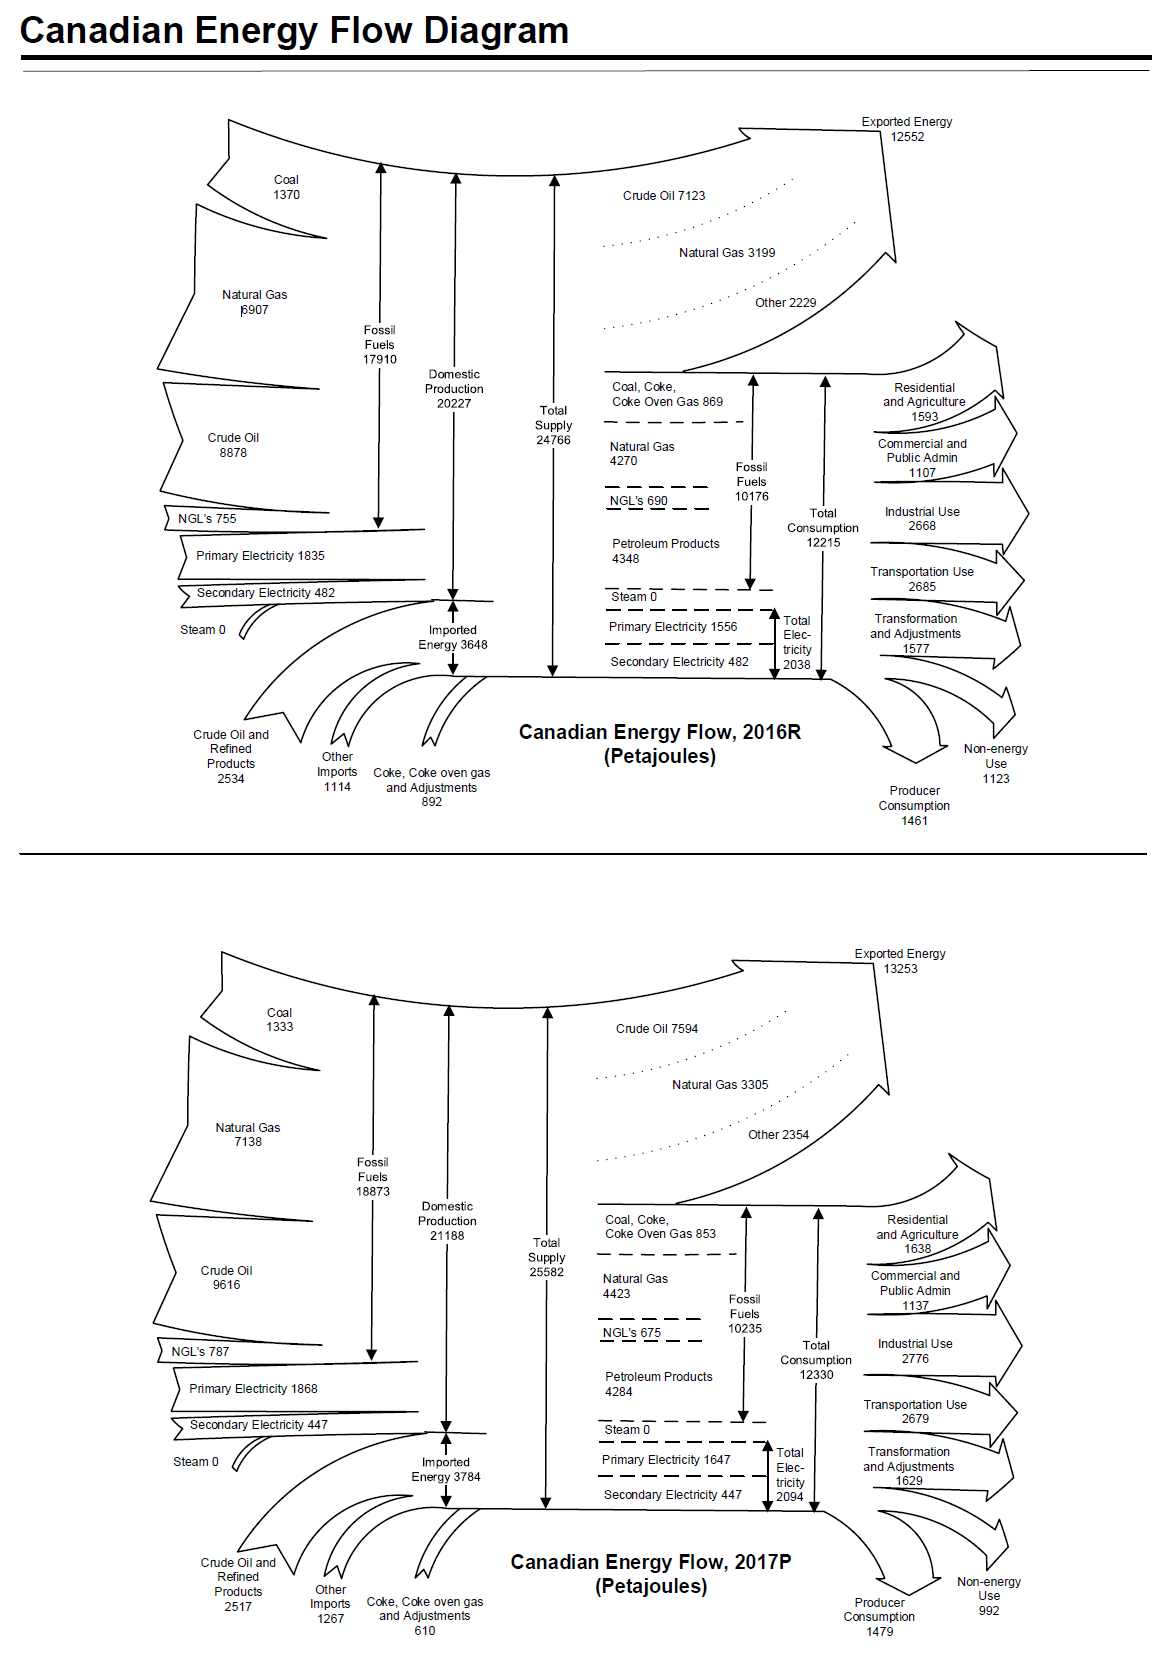

In [64]:
df_supdem = pd.read_csv('../data/38100096.csv')
df_supdem_metadata = pd.read_csv('../data/38100096_MetaData.csv')
pd.set_option('display.max_colwidth', None)
df_supdem["REF_DATE"].unique() 

df_supdem.iloc[300:320]
df_supdem['DGUID'].unique()

array(['2016A000011124'], dtype=object)